In [1]:
import pandas as pd
import csv 
import geopandas as gpd
from datetime import timedelta
from shapely.geometry import Point
import glob
from shapely import wkt

In [2]:
#read csv files and adjust to datetime
R_im_date = pd.read_csv('../data/Ramsey/RamseyImageryDates.csv', parse_dates=['date'])
years = range(2015, 2025)
R_sur_date = pd.DataFrame([pd.Timestamp(year=year, month=6, day=15) for year in years], columns = ['date'])
R_im_date['date'] = pd.to_datetime(R_im_date['date'])
R_sur_date['date'] = pd.to_datetime(R_sur_date['date'])

R_hyd = pd.read_csv('../data/Ramsey/RamseyHydroData.csv')
R_hyd.rename( columns={'Unnamed: 0':'date'}, inplace=True )
R_hyd['date'] = pd.to_datetime(R_hyd['date'])

R_surveyData = pd.read_csv('../data/Ramsey/Ramsey_surveyData.csv')

In [3]:
#find matching dates between survey and imagery
matching_dates = []
tolerance = timedelta(days = 5)

for date1 in R_sur_date['date']:
    exact_date = False
    tol = False 
    for date2 in R_im_date['date']:
        if date1 == date2:
            matching_dates.append({'Survey': date1, 'Imagery': date2})
            exact_date = True
    if not exact_date:
        for date2 in R_im_date['date']:
            if abs(date1 - date2) <= tolerance:
                matching_dates.append({'Survey': date1, 'Imagery': date2})
                tol = True
        if not tol: 
            for date2 in R_im_date['date']:
                if abs(date1-date2) < timedelta(days = 10): 
                    matching_dates.append({'Survey': date1, 'Imagery': date2})


matching_df = pd.DataFrame(matching_dates)


In [4]:
R_datessurData = pd.merge(matching_df, R_hyd, left_on = 'Survey', right_on = 'date', how = 'left')
R_datesimData = pd.merge(matching_df, R_hyd, left_on = 'Imagery', right_on = 'date')
#R_datessurData = R_datessurData.drop(columns = ['Imagery','date'])
#R_datesimData = R_datesimData.drop(columns = ['Survey','date'])


In [5]:
#sum precipitation for dates in between survey and imagery
def sum_pdatesbetween(d1, d2):
    r = pd.date_range(start=min(d1,d2), end=max(d1,d2))
    return R_hyd[R_hyd['date'].isin(r)]['P [mm]'].sum()

In [6]:
#making a dataframe to determine which imagery dates to use
Rh = pd.DataFrame([])

Rh['Survey'] = matching_df['Survey']
Rh['Imagery'] = matching_df['Imagery']
Rh['sum_P'] = [sum_pdatesbetween(R_datessurData.loc[i, 'Survey'], R_datesimData.loc[i, 'Imagery']) for i in range(len(Rh))]
Rh['Q_s-i'] = (R_datessurData['Q [mm/d]'] - R_datesimData['Q [mm/d]']) / R_datessurData['Q [mm/d]'] * 100
Rh['Use/not'] = ['not', 'not', 'not', 'use', 'not', 'not',
                 'not', 'not', 'not', 'not', 'use', 'not', 
                 'not', 'not', 'not', 'use', 'use', 'use',
                 'not', 'use', 'not', 'use']
Rh = Rh.fillna('')

conditions = (Rh['Use/not'] == 'not')

Rh = Rh[~conditions]

Rh = Rh.drop(columns=['Use/not'])

Rh

,Survey,Imagery,sum_P,Q_s-i
3,2017-06-15,2017-06-16,0.000000,50.0
10,2018-06-15,2018-06-14,11.789833,
15,2019-06-15,2019-06-15,0.000000,0.0
16,2020-06-15,2020-06-15,0.931333,0.0
17,2021-06-15,2021-06-15,0.000000,
19,2022-06-15,2022-06-14,0.000000,
21,2023-06-15,2023-06-15,0.000000,0.0


In [7]:
Rh.to_csv('../data/Ramsey/Ramsey_survey_imagery_hydro.csv', index = 'False')

In [8]:
#reading surveydata, making it into a geodataframe and adding x and y from the geometry to facilitate merge
R_surveyData['geometry'] = R_surveyData['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(R_surveyData, geometry = 'geometry', crs='EPSG:26912')

gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
gdf = gdf[['geometry', 'x', 'y', 'Year', 'wetdry']]
gdf['Year'] = gdf['Year'].astype(int) 
gdf['Year'] = pd.to_datetime(gdf['Year'].astype(str) + '-06-15')
gdf

,geometry,x,y,Year,wetdry
0,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2020-06-15,dry
1,POINT (565857.154 3479491.509),565857.153863,3.479492e+06,2020-06-15,dry
2,POINT (565853.784 3479487.815),565853.783803,3.479488e+06,2020-06-15,dry
3,POINT (565850.414 3479484.122),565850.413742,3.479484e+06,2020-06-15,dry
4,POINT (565847.044 3479480.428),565847.043681,3.479480e+06,2020-06-15,dry
...,...,...,...,...,...
13793,POINT (563918.761 3476832.571),563918.760958,3.476833e+06,2023-06-15,dry
13794,POINT (563918.030 3476837.517),563918.030009,3.476838e+06,2023-06-15,dry
13795,POINT (563917.299 3476842.463),563917.299060,3.476842e+06,2023-06-15,dry
13796,POINT (563916.568 3476847.409),563916.568111,3.476847e+06,2023-06-15,dry


In [73]:
R_mergedata = Rh.merge(gdf, left_on = 'Survey', right_on = 'Year')
R_mergedata = R_mergedata.drop(columns=['Year', 'sum_P', 'Q_s-i'])
#split on wet/dry
#R_mergewet = R_mergedata[(R_mergedata['wetdry'] == 'wet')]
#R_mergedry = R_mergedata[(R_mergedata['wetdry'] == 'dry')]
R_mergedata

,Survey,Imagery,geometry,x,y,wetdry
0,2018-06-15,2018-06-14,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,dry
1,2018-06-15,2018-06-14,POINT (565857.154 3479491.509),565857.153863,3.479492e+06,dry
2,2018-06-15,2018-06-14,POINT (565853.784 3479487.815),565853.783803,3.479488e+06,dry
3,2018-06-15,2018-06-14,POINT (565850.414 3479484.122),565850.413742,3.479484e+06,dry
4,2018-06-15,2018-06-14,POINT (565847.044 3479480.428),565847.043681,3.479480e+06,dry
...,...,...,...,...,...,...
5912,2023-06-15,2023-06-15,POINT (563918.761 3476832.571),563918.760958,3.476833e+06,dry
5913,2023-06-15,2023-06-15,POINT (563918.030 3476837.517),563918.030009,3.476838e+06,dry
5914,2023-06-15,2023-06-15,POINT (563917.299 3476842.463),563917.299060,3.476842e+06,dry
5915,2023-06-15,2023-06-15,POINT (563916.568 3476847.409),563916.568111,3.476847e+06,dry


In [69]:
gdf[gdf['geometry'] == gdf.iloc[0]['geometry']]

,geometry,x,y,Year,wetdry
0,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2020-06-15,dry
1013,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2016-06-15,dry
2017,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2014-06-15,dry
3026,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2009-06-15,wet
4264,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2018-06-15,dry
5268,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2012-06-15,dry
6536,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2015-06-15,dry
7461,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2021-06-15,dry
8385,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2013-06-15,dry
10649,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,2010-06-15,dry


<Axes: >

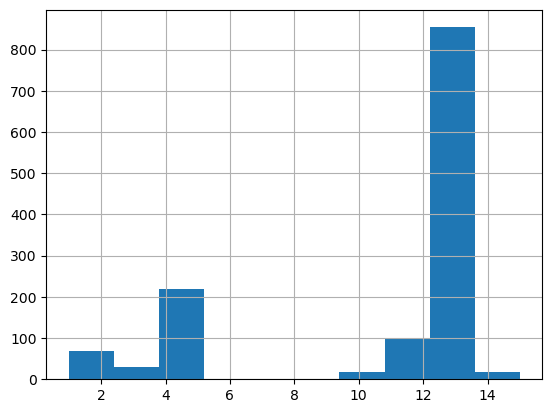

In [72]:
gdf.groupby('geometry').count().wetdry.hist()

array([[<Axes: title={'center': 'wetdry'}>]], dtype=object)

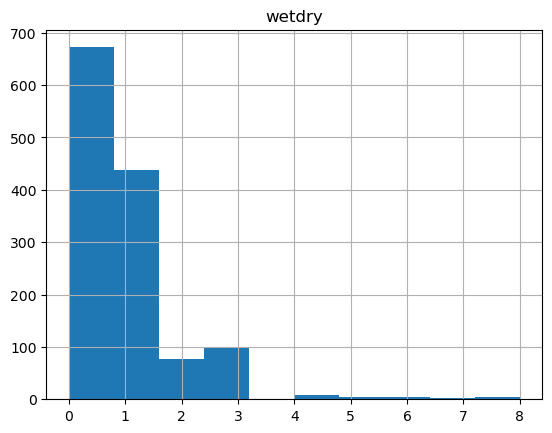

In [74]:
#Checking for perennial reaches by comparing surveys of each year
result = pd.DataFrame(gdf.groupby('geometry')['wetdry'].apply(lambda x: sum(x == 'wet')))
#result = result[(result['wetdry'] == True)]
result.hist()
#R_mergewet

In [70]:
#reading and concatenating the processed imagery 
path = '../data/Ramsey/processed_imagery'

processed_imagery = glob.glob(path + '/*.csv')
processed_imagery.sort(key = lambda x: int(x.split('_buffer_')[1].split('.')[0]))

con_ready_imagery = []
for processed in processed_imagery:
    df= pd.read_csv(processed)
    con_ready_imagery.append(df)

concatenated = pd.concat(con_ready_imagery)

In [72]:
concatenated['geometry'] = concatenated['geometry'].apply(wkt.loads)
gdf2 = gpd.GeoDataFrame(concatenated, geometry = 'geometry', crs='EPSG:26912')
gdf2

,blue,green,red,NIR,missing,NDWI,p,date,geometry
0,118.67,488.22,586.67,2784.22,0,-0.70,0,20231106,POINT (566246.049 3479852.011)
1,118.67,488.22,586.67,2784.22,0,-0.70,0,20231106,POINT (566246.049 3479852.011)
2,111.44,475.89,548.22,2778.33,0,-0.71,0,20231106,POINT (566241.855 3479849.289)
3,71.56,409.11,414.11,2665.22,0,-0.73,0,20231106,POINT (566237.660 3479846.568)
4,53.89,383.56,378.11,2560.78,0,-0.74,0,20231106,POINT (566233.466 3479843.847)
...,...,...,...,...,...,...,...,...,...
190605,0.00,0.00,0.00,0.00,0,NaN,0,20180503,POINT (563919.024 3476832.283)
190606,0.00,0.00,0.00,0.00,0,NaN,0,20180503,POINT (563918.293 3476837.229)
190607,0.00,0.00,0.00,0.00,0,NaN,0,20180503,POINT (563917.563 3476842.175)
190608,0.00,0.00,0.00,0.00,0,NaN,0,20180503,POINT (563916.832 3476847.122)
